In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
pjme = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv',
                  index_col = [0],
                  parse_dates = [0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [ ]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(15, 6),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

In [5]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

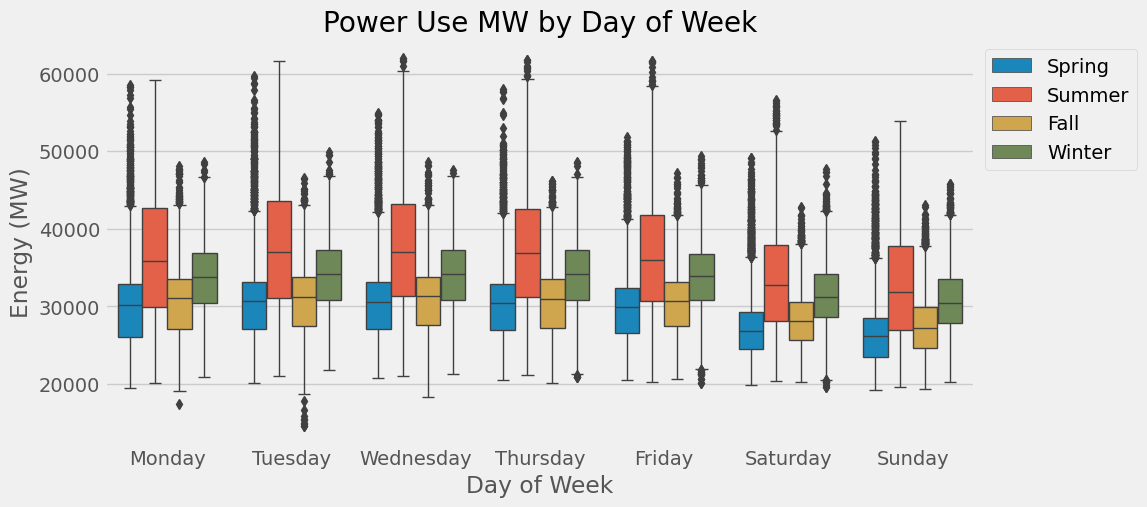

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

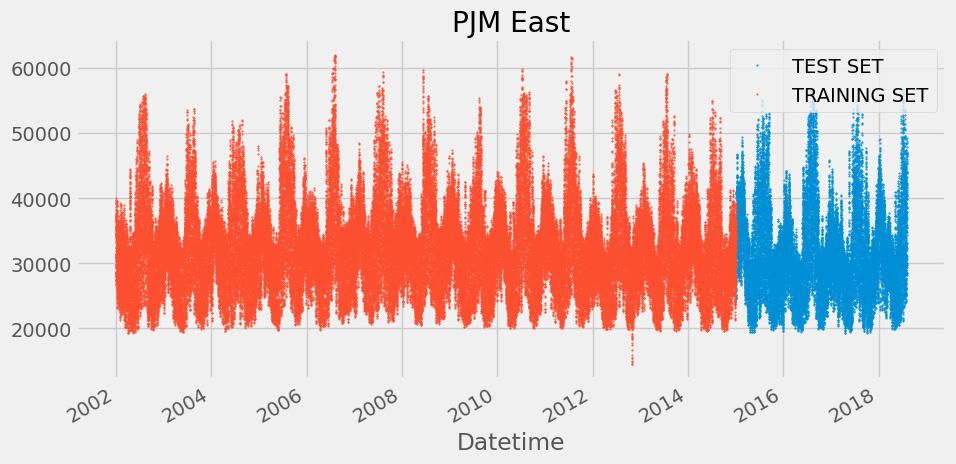

In [7]:
#train /test Split
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

In [8]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [9]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

22:36:02 - cmdstanpy - INFO - Chain [1] start processing
22:38:25 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 5.81 s, sys: 469 ms, total: 6.28 s
Wall time: 2min 29s


In [10]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [11]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31208.190460,23668.871725,32869.091726,31208.190460,31208.190460,-2834.632163,-2834.632163,-2834.632163,-4430.393890,...,1281.420045,1281.420045,1281.420045,314.341681,314.341681,314.341681,0.0,0.0,0.0,28373.558297
1,2015-01-01 02:00:00,31208.152940,22255.062315,30962.585584,31208.152940,31208.152940,-4339.002396,-4339.002396,-4339.002396,-5927.319301,...,1272.662195,1272.662195,1272.662195,315.654711,315.654711,315.654711,0.0,0.0,0.0,26869.150544
2,2015-01-01 03:00:00,31208.115419,21736.030466,30533.507410,31208.115419,31208.115419,-5210.686384,-5210.686384,-5210.686384,-6790.394198,...,1262.698585,1262.698585,1262.698585,317.009228,317.009228,317.009228,0.0,0.0,0.0,25997.429035
3,2015-01-01 04:00:00,31208.077899,21101.285307,30352.371143,31208.077899,31208.077899,-5352.216945,-5352.216945,-5352.216945,-6922.275016,...,1251.652813,1251.652813,1251.652813,318.405259,318.405259,318.405259,0.0,0.0,0.0,25855.860954
4,2015-01-01 05:00:00,31208.040379,21929.043481,30797.422208,31208.040379,31208.040379,-4677.852763,-4677.852763,-4677.852763,-6237.356273,...,1239.660683,1239.660683,1239.660683,319.842827,319.842827,319.842827,0.0,0.0,0.0,26530.187616


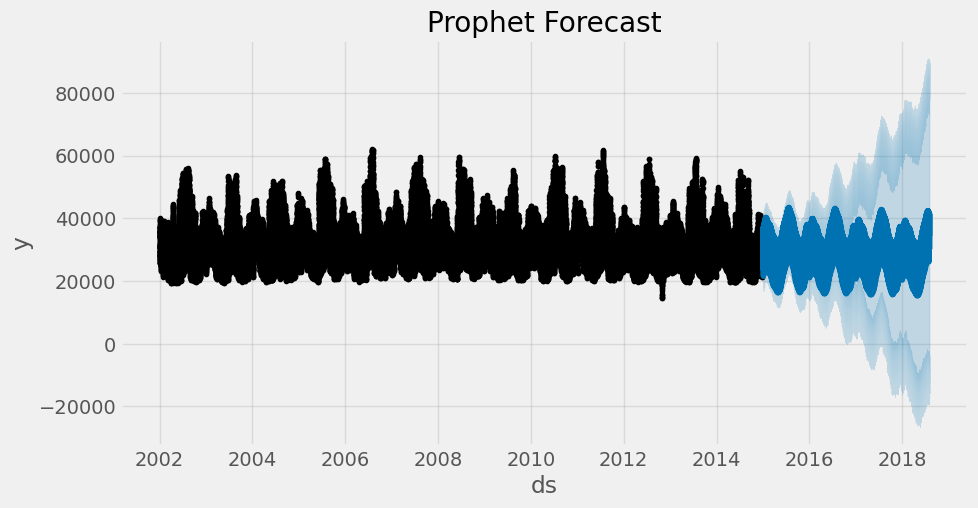

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

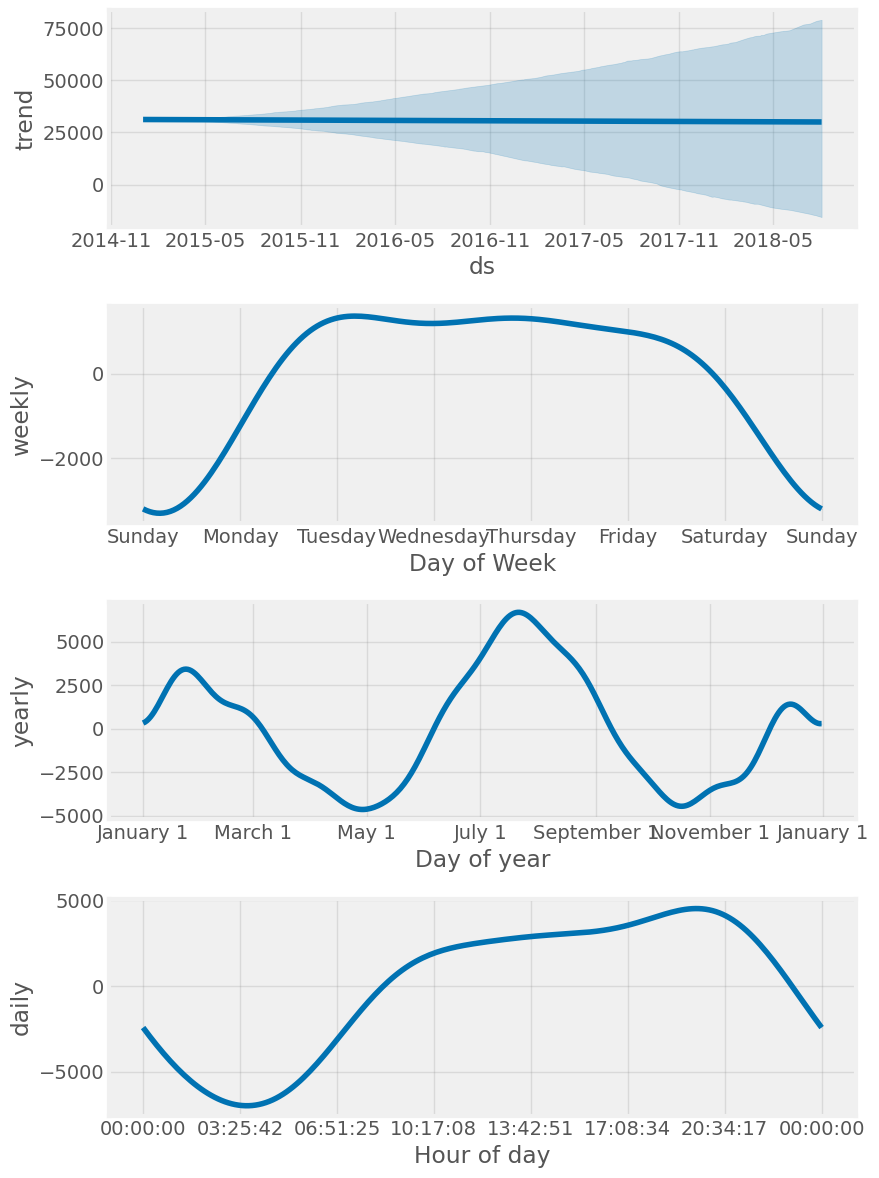

In [13]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

#compare

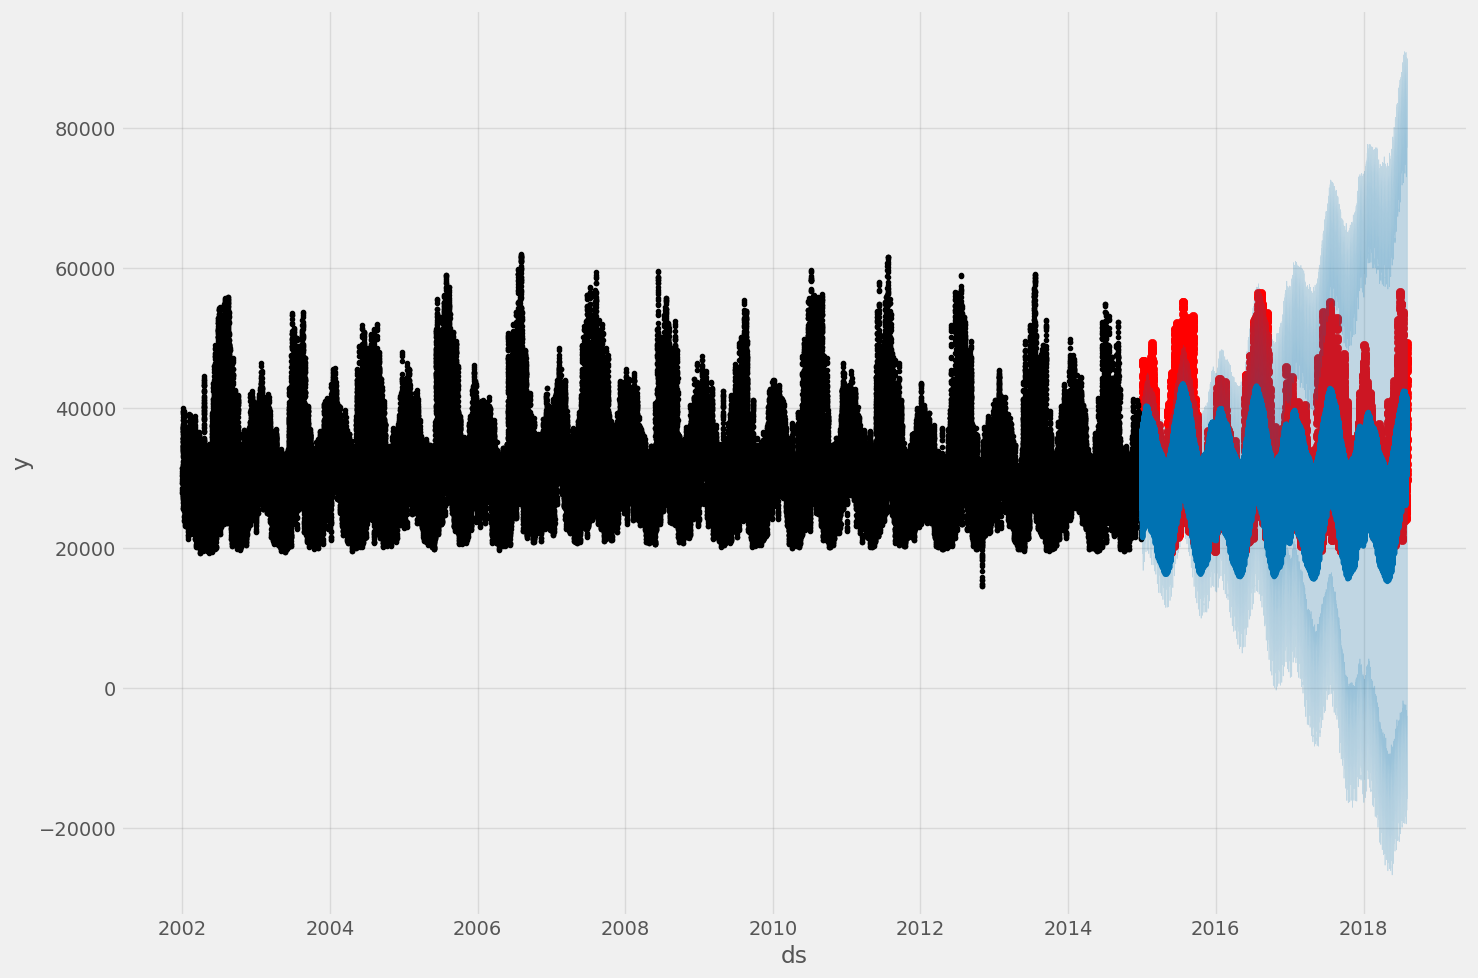

In [28]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 10))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

In [39]:
'''
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

ax.set_xbound(lower='01-01-2015',
              upper='02-01-2015')

ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')
'''

"\nfig, ax = plt.subplots(figsize=(10, 5))\nax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')\nfig = model.plot(pjme_test_fcst, ax=ax)\n\nax.set_xbound(lower='01-01-2015',\n              upper='02-01-2015')\n\nax.set_ylim(0, 60000)\nplot = plt.suptitle('January 2015 Forecast vs Actuals')\n"

In [41]:
'''
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()
'''

"\n# Plot the forecast with the actuals\nf, ax = plt.subplots(figsize=(15, 5))\nax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')\nfig = model.plot(pjme_test_fcst, ax=ax)\nax.set_xbound(lower='01-01-2015', upper='01-08-2015')\nax.set_ylim(0, 60000)\nax.set_title('First Week of January Forecast vs Actuals')\nplt.show()\n"

In [42]:
#Evaluate the model with error Metrics
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6616.600998885614

In [43]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5182.550981073254

In [44]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.5092365437919

In [45]:
# Adding holidays

In [46]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [47]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

22:56:16 - cmdstanpy - INFO - Chain [1] start processing
22:58:57 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 7.33 s, sys: 439 ms, total: 7.77 s
Wall time: 2min 48s


In [48]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

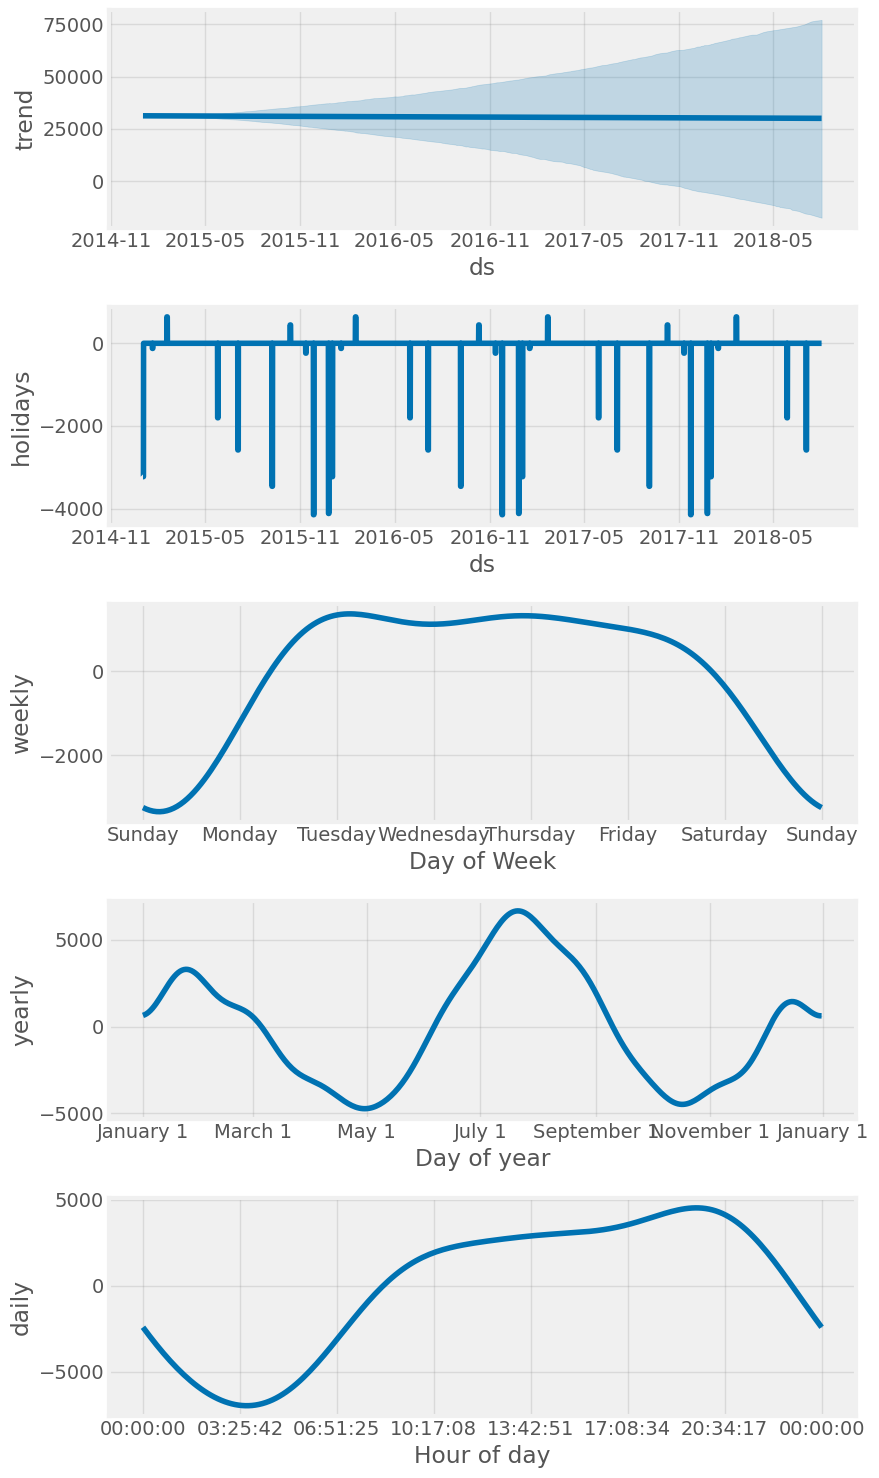

In [49]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

In [51]:
'''
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015',
              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')
'''

"\nfig, ax = plt.subplots(figsize=(10, 5))\nax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')\nfig = model.plot(pjme_test_fcst_with_hols, ax=ax)\nax.set_xbound(lower='07-01-2015',\n              upper='07-07-2015')\nax.set_ylim(0, 60000)\nplot = plt.suptitle('July 4 Predictions vs Actual')\n"

In [52]:
# now Calculate error
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6638.807593030567

In [53]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5200.565072848214

In [54]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.563039872247355

In [55]:
#future prediction
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [56]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25555.343185
1,2015-01-01 02:00:00,24053.371498
2,2015-01-01 03:00:00,23183.815005
3,2015-01-01 04:00:00,23044.178964
4,2015-01-01 05:00:00,23720.146970
